# Time Series Analysis - Part 3 :  ARMA and ARIMA models

In this third post in the mini-series on time series analysis, we combine the Autoregressive models and Moving Average models we studied in the previous notebook to produce more sophisticated models - Auto Regressive Moving Average(ARMA) and Auto Regressive Integrated Moving Average(ARIMA) models.


In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC','DOW','AAPL','MSFT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1))

Processing data for stock: ^GSPC
Processing data for stock: DOW
Processing data for stock: AAPL
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


In [3]:
lrets['^GSPC'].dropna()

2014-12-31   -0.010364
2015-01-02   -0.000340
2015-01-05   -0.018447
2015-01-06   -0.008933
2015-01-07    0.011563
                ...   
2017-12-22   -0.000458
2017-12-26   -0.001059
2017-12-27    0.000791
2017-12-28    0.001832
2017-12-29   -0.005197
Name: ^GSPC, Length: 756, dtype: float64

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### Autoregressive Moving Average Models - ARMA(p, q)

ARMA model is simply the merger between AR(p) and MA(q) models:

* AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets (market participant effects). 
* MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

Hence, an ARMA model attempts to capture both of these aspects when modelling financial time series. Note that an ARMA model does not take into account volatility clustering, a key empirical phenomena of many financial time series which we will discuss later. 

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$ 

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$

An ARMA model will often require fewer parameters than an AR(p) or MA(q) model alone. That is, it is redundant in its parameters

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3]. 

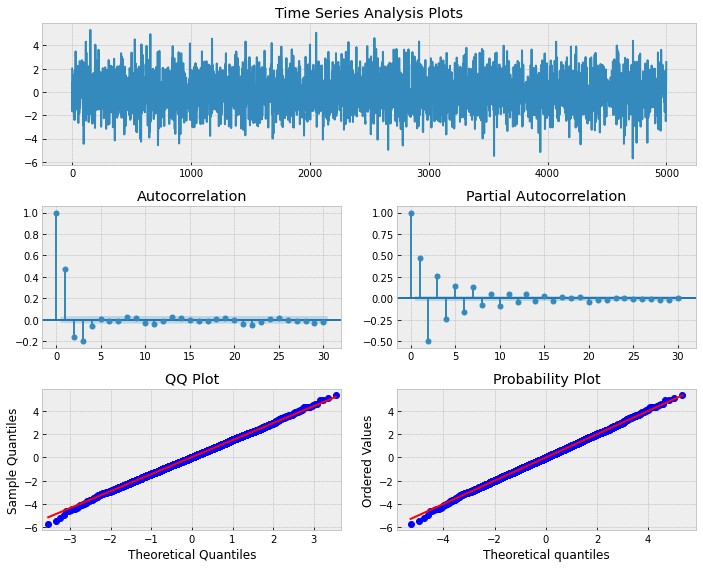

In [5]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)


In [6]:
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7084.557
Method:                           mle   S.D. of innovations              0.998
Date:                Sun, 01 Nov 2020   AIC                          14179.113
Time:                        18:51:19   BIC                          14211.699
Sample:                             0   HQIC                         14190.534
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4916      0.063      7.853      0.000       0.369       0.614
ar.L2.y       -0.2636      0.015    -17.728      0.000      -0.293      -0.234
ma.L1.y        0.5258      0.065      8.113      0.0

If you run the above code a few times, you may notice that the confidence intervals for some coeffecients may not actually contain the original parameter value. This outlines the danger of attempting to fit models to data, even when we know the true parameter values!

However, for trading purposes we just need to have a predictive power that exceeds chance and produces enough profit above transaction costs, in order to be profitable in the long run.

**So how do we decide the values of $p$ and $q$ ?**

We exapnd on the method described in previous sheet. To fit data to an ARMA model, we use the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) across a subset of values for p,q to find the model with minimum AIC and then apply the [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) to determine if a good fit has been achieved, for particular values of p,q. If the p value of the test is greater the required significance, we can conclude that the residuals are independent and white noise.


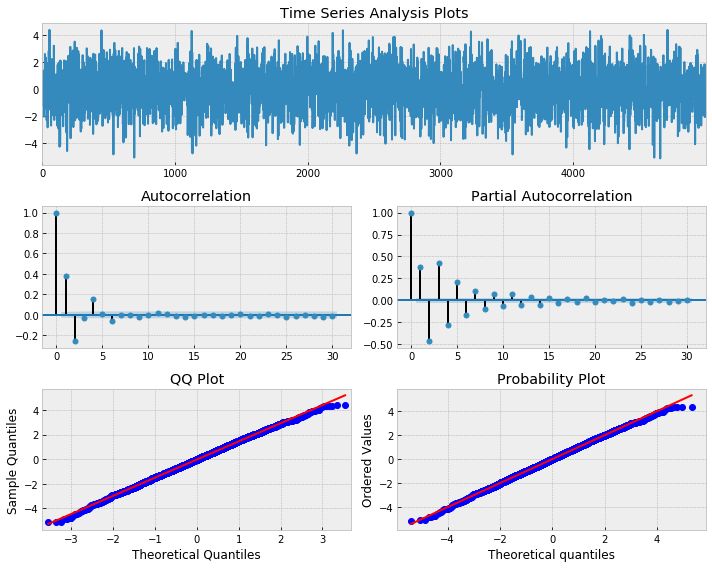

In [7]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.4,0.25] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.4, 0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)


In [8]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))


aic: 14134.10121 | order: (4, 2)


In [9]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([7.53229585]), array([0.99453761]))

Notice that the p-value is greater than 0.05, which states that the residuals are independent at the 95% level and thus an ARMA(3,2) model provides a good model fit (ofcourse we knew that).

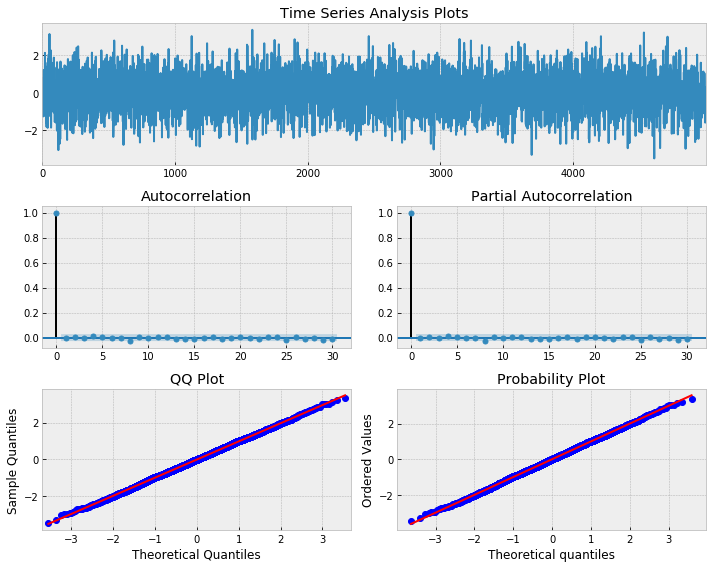

In [10]:
_ = tsplot(best_mdl.resid, lags=max_lag)

Also the model residuals look like white noise.

In [11]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


Next we fit an ARMA model to SPX returns.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

aic: -5188.56514 | order: (4, 4)


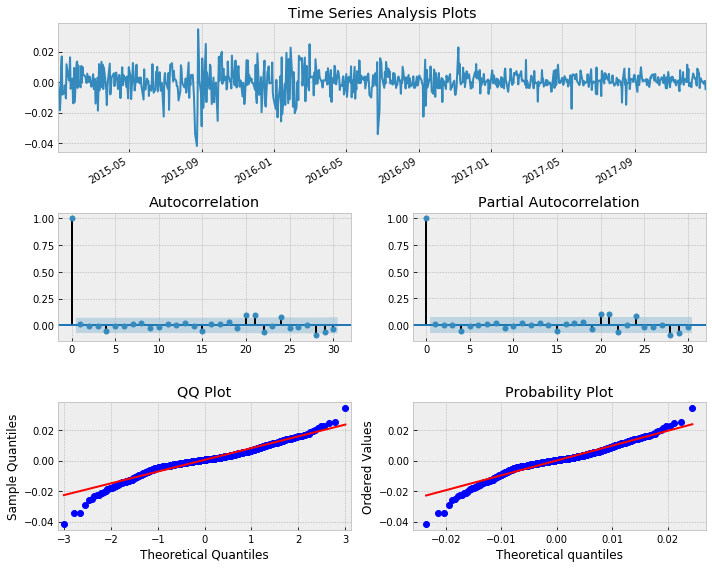

In [12]:
from numpy.linalg import LinAlgError
# Fit ARMA model to SPX returns

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(1,5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(TS, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except (ValueError, LinAlgError) as e: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

_ = tsplot(best_mdl.resid, lags=max_lag)


The best fitting model has ARMA(3,2). Notice that there are some significant peaks, especially at higher lags. This is indicative of a poor fit. Let's perform a Ljung-Box test to see if we have statistical evidence for this:

In [13]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)


(array([15.86516991]), array([0.72495288]))

As we suspected, the p-value is less that 0.05 and as such we cannot say that the residuals are a realisation of discrete white noise. Hence there is additional autocorrelation in the residuals that is not explained by the fitted ARMA(3,2) model. This is obvious from the plot of residuals as well, we can see areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured. 

### Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

ARIMA is a natural extension to the class of ARMA models - they are used because they can reduce a non-stationary series to a stationary series using a sequence of differences. 

As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of nonstationary Guassian random walk and proved that it equals stationary white noise.

ARIMA essentially performs same function, but does so repeatedly, $d$ times, in order to reduce a non-stationary series to a stationary one.

**Without diving too deeply into the equation, just know that a time series $x_t$ is integrated of order $d$ if we difference the series $d$ times and receive a discrete white noise series.**


A time series $x_t$ is an autoregressive integrated moving average model of order p, d, q, ARIMA(p,d,q) if the series $x_t$ is differenced $d$ times, and it then follows an ARMA(p,q) process.

Let's simulate an ARIMA(2,1,1) model, with the $\alpha = [0.5, -0.25], \beta=-0.5$. Like before we will fit an ARIMA model to our simulated data, attempt to recover the parameters.

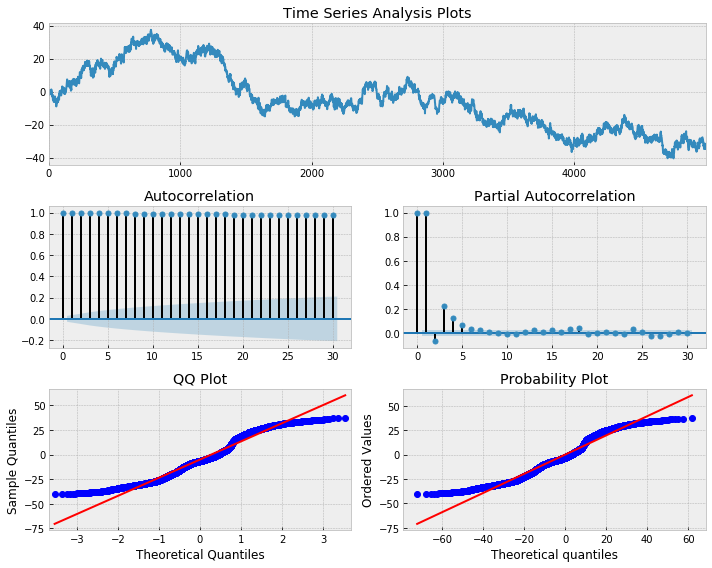

In [14]:
# Simulate an ARIMA(2,1,1) model with alphas=[0.5,-0.25] and betas=[-0.5]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5,-0.25])
betas = np.array([-0.5])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma11 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arima111 = arma11.cumsum()
_ = tsplot(arima111, lags=max_lag)

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



aic: 14309.48288 | order: (2, 1, 1)


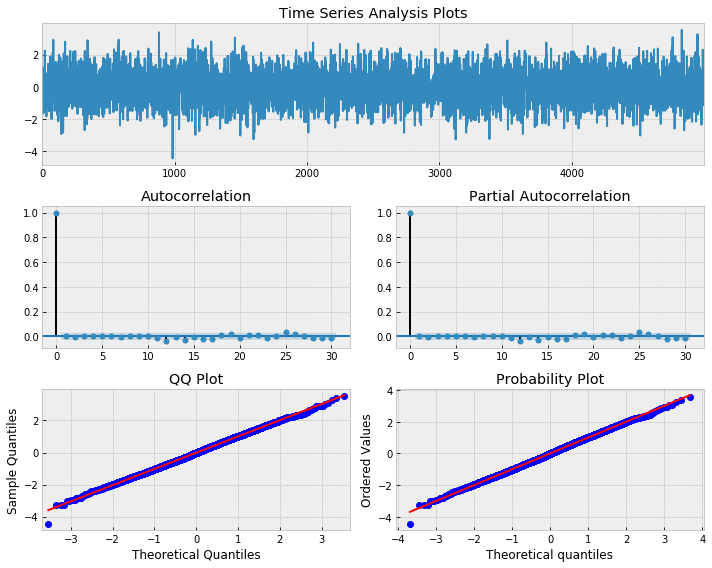

In [15]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arima111, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

As expected, we predict a ARIMA(2,1,1) model and the residuals looking like a realisation of discrete white noise:

In [16]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([22.17722719]), array([0.33097178]))

We perform the Ljung-Box test and find the p-value is significantly larger than 0.05 and as such we can state that there is strong evidence for discrete white noise being a good fit to the residuals. Hence, the ARIMA(2,1,1) model is a good fit, as expected. And our standard test for normality on residuals is below.

In [17]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPX returns. We use the AIC to evaluate each model. The lowest AIC wins. 

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index 

aic: -5188.75603 | order: (4, 0, 0)


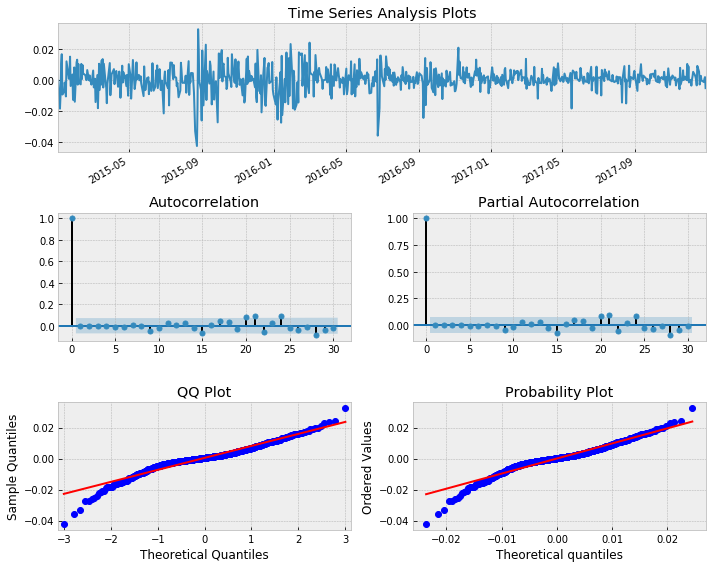

In [18]:
# Fit ARIMA(p, d, q) model to SPX log returns
# pick best order and final model based on aic

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf 
best_order = None
best_mdl = None


pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. The result is essentially identical to the ARMA(3, 2) model we fit above. Clearly this ARIMA model has not explained the conditional volatility in the series either! The ljung box test below also shows a pvalue of less than 0.05

In [19]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([16.29335655]), array([0.69826622]))

#### Excluding periods of conditional Volatility

Let's try the same model on SPX data from 2010-2016

In [20]:
startDateStr = '2010/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Processing data for stock: ^GSPC
20% done...
40% done...
60% done...
80% done...


c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\david\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\dav

aic: -11628.34467 | order: (3, 1, 4)


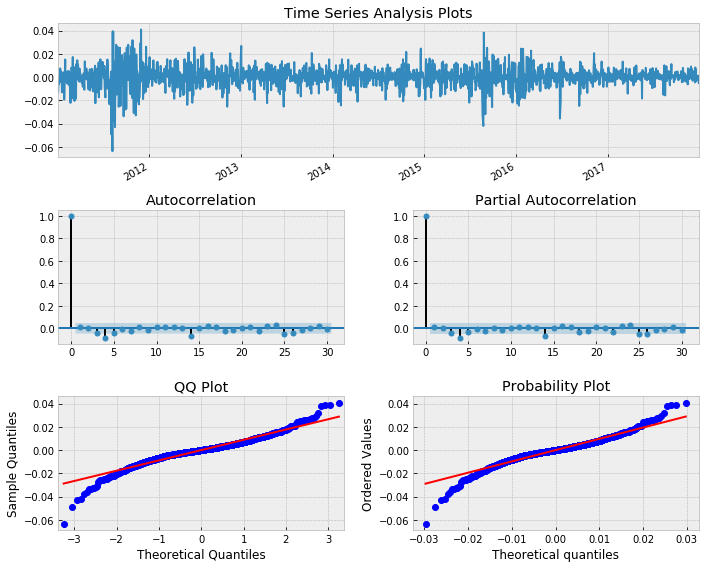

In [21]:
# Fit ARIMA(p, d, q) model to SPX log returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [22]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([29.7722136]), array([0.07362965]))

Our residuals look much closer to white noise and the p-value of our test is now greater than 0.05! How did our model suddenly improve?

In [23]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


We deliberately truncated the S&P500 data to start from 2010 onwards, which conveniently excludes the volatile periods around 2007-2008. Hence we have excluded a large portion of the S&P500 where we had excessive volatility clustering. This impacts the serial correlation of the series and hence has the effect of making the series seem "more stationary" than it has been in the past.

*This is a very important point*. When analysing time series we need to be extremely careful of conditionally heteroscedastic series, such as stock market indexes. In quantitative finance, trying to determine periods of differing volatility is often known as "regime detection". It is one of the harder tasks to achieve!

#### Forecasting

Now your patience gets rewarded! We have at least accumulated enough knowledge to make a simple forecast of future returns. We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [24]:
# Create a 21 day forecast of SPX returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-12-29,0.000738,-0.016578,-0.022018,0.018053,0.023494
2017-12-30,0.000576,-0.016755,-0.022201,0.017907,0.023353
2017-12-31,0.000506,-0.016834,-0.022282,0.017846,0.023295
2018-01-01,-0.000140,-0.017504,-0.022961,0.017224,0.022680
2018-01-02,0.001061,-0.016341,-0.021809,0.018463,0.023931


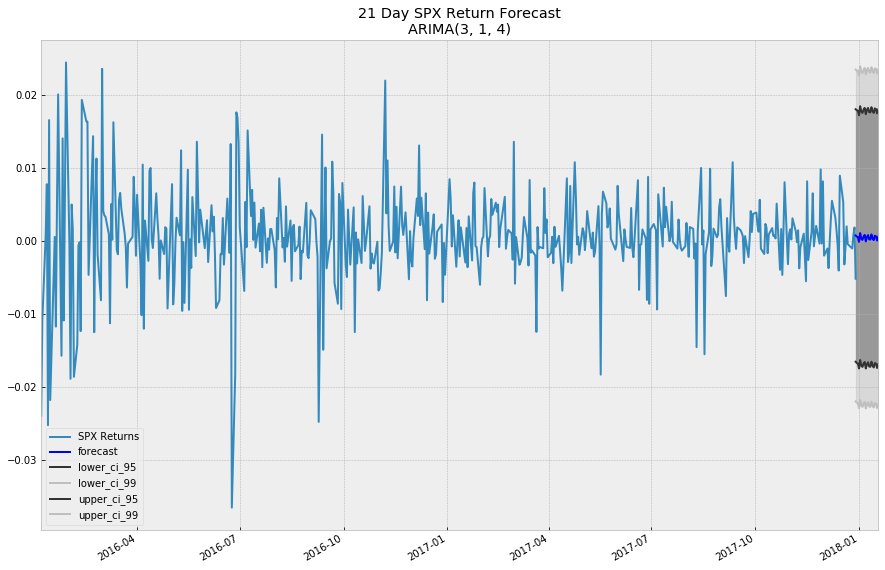

In [25]:
# Plot 21 day forecast for SPX returns

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lrets['^GSPC'].iloc[-500:].copy()
ts.plot(ax=ax, label='SPX Returns')
# in sample prediction
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
#pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPX Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

Now that we have the ability to fit and forecast models such as ARIMA, we're very close to being able to create strategy indicators for trading.

In the next notebook we are going to take a look at the Generalised Autoregressive Conditional Heteroscedasticity (GARCH) model and use it to explain more of the serial correlation in certain equities and equity index series.